In [40]:
import numpy as np
import pandas as pd
import glob
import string

from sklearn.model_selection import train_test_split
from nltk.tag import pos_tag

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Importing Dataset

We import the CSV files

In [2]:
all_data = pd.DataFrame()
for f in glob.glob("./data/*.csv"):
    df = pd.read_csv(f)
    all_data = all_data.append(df,ignore_index=True)

In [3]:
all_data.info()
all_data = all_data.sample(frac=1).reset_index(drop=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2232 entries, 0 to 2231
Data columns (total 20 columns):
id                       2232 non-null float64
id_str                   2232 non-null object
screen_name              2232 non-null object
location                 1420 non-null object
description              1911 non-null object
url                      1212 non-null object
followers_count          2232 non-null int64
friends_count            2232 non-null int64
listedcount              2232 non-null int64
created_at               2232 non-null object
favourites_count         2232 non-null int64
verified                 2232 non-null bool
statuses_count           2232 non-null int64
lang                     2232 non-null object
status                   2203 non-null object
default_profile          2232 non-null bool
default_profile_image    2232 non-null bool
has_extended_profile     2154 non-null object
name                     2232 non-null object
bot                      2232

In [4]:
all_data.head(4)

,id,id_str,screen_name,location,description,url,followers_count,friends_count,listedcount,created_at,favourites_count,verified,statuses_count,lang,status,default_profile,default_profile_image,has_extended_profile,name,bot
0,1.663453e+08,166345340,paolitagdiaz,"Ponta Grossa, ParanՍ",Argentina morando no Brasil.,NaN,136,300,5,7/13/10,95,False,1748,es,null,False,False,False,Paola Diaz,0
1,1.654802e+07,16548023,9GAG,Universe,9GAG is the best content platform for millenni...,http://t.co/B5GZFPUXYM,8740007,9,9992,10/1/08,1127,True,36200,en,"Status(id_str='841393552085135360', contributo...",False,False,False,9GAG,0
2,9.236775e+07,92367751,jessicaalba,NaN,"Mom of 2, Founder of The Honest Company, amate...",https://t.co/spEzR79he1,9515386,1329,0,Tue Nov 24 21:17:31 +0000 2009,1141,True,5942,en,"{u'contributors': None, u'truncated': False, u...",False,False,False,Jessica Alba,0
3,1.539694e+09,1539693919,NSA_PRISMbot,We Are Everywhere.,An experiment in speculative surveillance.,NaN,680,36,79,6/22/13,6,False,7068,en,"Status(contributors=None, truncated=False, tex...",True,False,False,NSA PRISM,0


In [5]:
train, test = train_test_split(all_data, test_size = 0.2)

In [6]:
train.shape , test.shape

((1785, 20), (447, 20))

# Visualizing Data

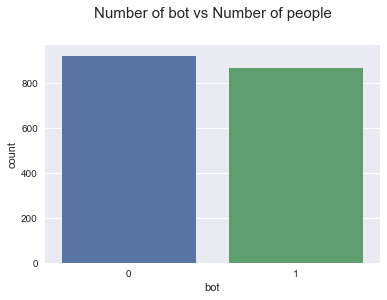

In [7]:
plt.title('Number of bot vs Number of people', y=1.1, size=15)
sns.countplot('bot', data=train)

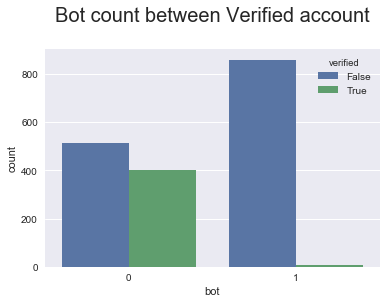

In [8]:
plt.title('Bot count between Verified account', size=20, y=1.1)
sns.countplot(x = 'bot', hue='verified', data=train)

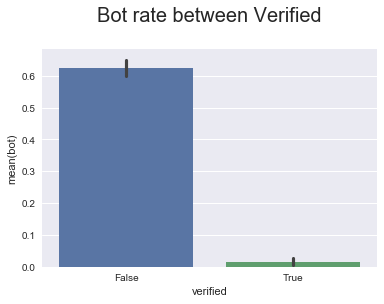

In [9]:
plt.title('Bot rate between Verified', size=20, y=1.1)
sns.barplot(x='verified', y='bot', data=train)

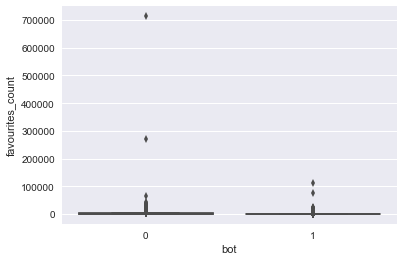

In [10]:
sns.boxplot(x='bot', y='favourites_count', data=train)

count    1.785000e+03
mean     9.689370e+05
std      5.355878e+06
min      0.000000e+00
25%      4.500000e+01
50%      3.430000e+02
75%      1.307100e+04
max      9.632156e+07
Name: followers_count, dtype: float64

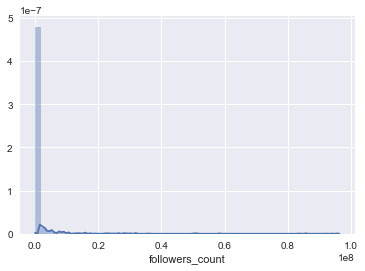

In [11]:
sns.distplot(train['followers_count'])
train['followers_count'].describe()

# Transforming Features

Since we must deal with numerical feature, we should convert all the following in a binary vector 0/1.
1. verified 
2. default_profile 
3. default_profile_image 
4. has_extended_profile 

In [12]:
train['default_profile'].describe()

count      1785
unique        2
top       False
freq        982
Name: default_profile, dtype: object

In [7]:
def returnDates(x):
    formated_date = ''
    months = {'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}
    if x.startswith('"') and x.endswith('"'): x = x[1:-1]
    date_split = x.split(' ')
    if len(date_split) == 1:
        _date = date_split[0].split('/')
        _date[2] = '20'+_date[2]
        formated_date = ''.join(map(str,_date))
        #print formated_date , date_split, pd.to_datetime(formated_date, format='%m%d%Y', errors='coerce')
    elif len(date_split) == 2:
        _date = date_split[0].split('/')
        formated_date = ''.join(map(str,[_date[1],_date[0],_date[2]]))
        #print formated_date , date_split, pd.to_datetime(formated_date, format='%m%d%Y', errors='coerce')
    elif len(date_split) == 6:
        m = months[date_split[1]]
        formated_date = ''.join(map(str,[m,date_split[2],date_split[5]]))
        if formated_date[-1] == '"': formated_date = formated_date[:-1]
        #print formated_date, date_split, pd.to_datetime(formated_date, format='%m%d%Y', errors='coerce')
    
    return pd.to_datetime(formated_date, format='%m%d%Y', errors='coerce')

In [9]:
def simplfy_followerscount(df):
    df.followers_count = df.followers_count.fillna(-0.5)
    bins = (-1, 0, 46,358,14917,96321560)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.followers_count, bins, labels=group_names)
    df.followers_count = categories
    return df  

def simplfy_friendscount(df):
    df['friends_count'] = df['friends_count'].fillna(-0.5)
    bins = (-1, 0, 10,197,671,978964)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df['friends_count'], bins, labels=group_names)
    df['friends_count'] = categories
    return df    

def simplfy_listedcount(df):
    df['listedcount'] = df['listedcount'].fillna(-0.5)
    bins = (-1, 0, 1,18,360,222411)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df['listedcount'], bins, labels=group_names)
    df['listedcount'] = categories
    return df    

def simplfy_favouritescount(df):
    df['favourites_count'] = df['favourites_count'].fillna(-0.5)
    bins = (-1,0,25,484,714021)
    group_names = ['1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df['favourites_count'], bins, labels=group_names)
    df['favourites_count'] = categories
    return df  

def simplfy_statusescount(df):
    df['statuses_count'] = df['statuses_count'].fillna(-0.5)
    bins = (-1, 0,178,2290,10025,6863363)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df['statuses_count'], bins, labels=group_names)
    df['statuses_count'] = categories
    return df 

def drop_features(df):
    return df.drop(['id', 'id_str', 'location','lang'], axis=1)

def replace_None(df):
    df['has_extended_profile'] = df['has_extended_profile'].fillna('N/A')
    df['status'] = df['status'].fillna('N/A')
    return df

def format_date(df):
    df['created_at'] = df['created_at'].apply(returnDates)
    return df;

def transform_features(df):
    df = simplfy_followerscount(df)
    df = simplfy_friendscount(df)
    df = simplfy_listedcount(df)
    df = simplfy_favouritescount(df)
    df = simplfy_statusescount(df)   
    df = drop_features(df)
    df = replace_None(df)  
    df = format_date(df)
    return df

train = transform_features(train)
test = transform_features(test)
train.head()

,screen_name,description,url,followers_count,friends_count,listedcount,created_at,favourites_count,verified,statuses_count,status,default_profile,default_profile_image,has_extended_profile,name,bot
2085,Saloni146,NaN,NaN,2_quartile,2_quartile,Unknown,2014-03-22,4_quartile,False,1_quartile,"Status(created_at=datetime.datetime(2016, 12, ...",True,False,False,Saloni Singh,0
1664,xbangtan1,Giving you a free follow and you can help me b...,NaN,2_quartile,4_quartile,Unknown,2016-07-06,2_quartile,False,1_quartile,"{'truncated': False, 'entities': {'user_mentio...",True,False,False,free follow read bio,1
375,thedreamstream,So we all love hearing about other ppls dreams...,NaN,2_quartile,3_quartile,2_quartile,2009-06-27,1_quartile,False,3_quartile,"Status(created_at=datetime.datetime(2010, 1, 2...",False,False,False,The Dream Stream,1
1984,Stroke9,Band. Backpacks. Beers.,https://t.co/FvKfaF9lb3,4_quartile,3_quartile,4_quartile,2009-02-06,4_quartile,True,3_quartile,"{u'contributors': None, u'truncated': False, u...",False,False,False,Stroke 9,0
1618,HEoxt25,The Association of Ontario Midwives is the pro...,NaN,1_quartile,3_quartile,Unknown,2016-10-14,3_quartile,False,1_quartile,null,True,False,False,HEoxt25,1


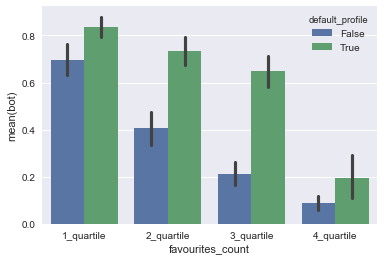

In [10]:
sns.barplot(x="favourites_count", y="bot", hue="default_profile", data=train);

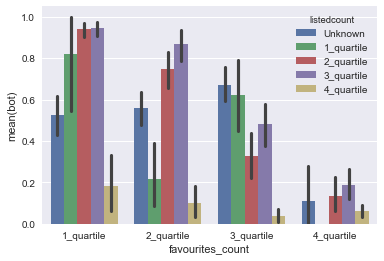

In [11]:
sns.barplot(x="favourites_count", y="bot", hue="listedcount", data=train);

# Final Encoding

The LabelEncoder in Scikit-learn will convert each unique string value into a number, making out data more flexible for various algorithms.

In [12]:
from sklearn import preprocessing
def encode_features(df_train, df_test):
    features = ['followers_count','friends_count','listedcount','favourites_count','verified','statuses_count', \
                'default_profile','default_profile_image','has_extended_profile']
    df_combined = pd.concat([df_train[features], df_test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test
    
train, test = encode_features(train, test)
train.head()

/Users/Vignesh/anaconda2/lib/python2.7/site-packages/numpy/lib/arraysetops.py:259: FutureWarning: numpy equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  return aux[:-1][aux[1:] == aux[:-1]]


,screen_name,description,url,followers_count,friends_count,listedcount,created_at,favourites_count,verified,statuses_count,status,default_profile,default_profile_image,has_extended_profile,name,bot
2085,Saloni146,NaN,NaN,2,1,4,2014-03-22,3,0,0,"Status(created_at=datetime.datetime(2016, 12, ...",1,0,0,Saloni Singh,0
1664,xbangtan1,Giving you a free follow and you can help me b...,NaN,2,3,4,2016-07-06,1,0,0,"{'truncated': False, 'entities': {'user_mentio...",1,0,0,free follow read bio,1
375,thedreamstream,So we all love hearing about other ppls dreams...,NaN,2,2,1,2009-06-27,0,0,2,"Status(created_at=datetime.datetime(2010, 1, 2...",0,0,0,The Dream Stream,1
1984,Stroke9,Band. Backpacks. Beers.,https://t.co/FvKfaF9lb3,4,2,3,2009-02-06,3,1,2,"{u'contributors': None, u'truncated': False, u...",0,0,0,Stroke 9,0
1618,HEoxt25,The Association of Ontario Midwives is the pro...,NaN,1,2,4,2016-10-14,2,0,0,null,1,0,0,HEoxt25,1


In [21]:
train_output = pd.DataFrame(data=train, columns =list(train))
test_output = pd.DataFrame(data=test, columns =list(test))

# Use pandas to write the comma-separated output file
train_output.to_csv("./cleanedData/Bot_Training.csv", index=False)
test_output.to_csv("./cleanedData/Bot_Testing.csv", index=False)

# Splitting up the Training Data


First, separate the features(X) from the labels(y).
* X_all: All features minus the value we want to predict (Bot).
* y_all: Only the value we want to predict.

Second, use Scikit-learn to randomly shuffle this data into four variables. In this case, Training 80% of the data, then testing against the other 20%.

Later, this data will be reorganized into a KFold pattern to validate the effectiveness of a trained algorithm

In [13]:
from sklearn.model_selection import train_test_split

X_all = train.drop(['bot', 'screen_name'], axis=1)
y_all = train['bot']

num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, random_state=23)

In [14]:
X_train.shape, y_train.shape

((1428, 14), (1428,))

In [15]:
X_test.shape, y_test.shape

((357, 14), (357,))

In [67]:
def get_Noun(x):
    word = x.strip()
    count = 0
    tagged_sent = pos_tag(word.split())
    for w in tagged_sent:
        if w[1] == 'NNP':
            count+=1
        if w[1] == 'VBZ':
            count-=1
    return count

In [68]:
df['name'] = df['name'].fillna("")
train['NounCount'] = df['name'].apply(get_Noun)

In [69]:
train['NounCount'].describe()

count    939.000000
mean       1.436635
std        0.932120
min        0.000000
25%        0.000000
50%        2.000000
75%        2.000000
max        3.000000
Name: NounCount, dtype: float64

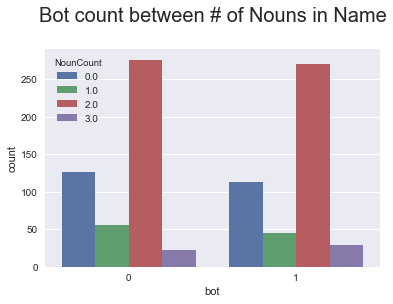

In [70]:
plt.title('Bot count between # of Nouns in Name', size=20, y=1.1)
sns.countplot(x = 'bot', hue='NounCount', data=train)

In [71]:
train['created_at'][0]

Timestamp('2010-07-13 00:00:00')

In [73]:
from datetime import date
import calendar
train['days'] = train['created_at'].apply(lambda x: calendar.day_name[x.weekday()])

In [74]:
train['days'].describe()

count         1785
unique           7
top       Thursday
freq           291
Name: days, dtype: object

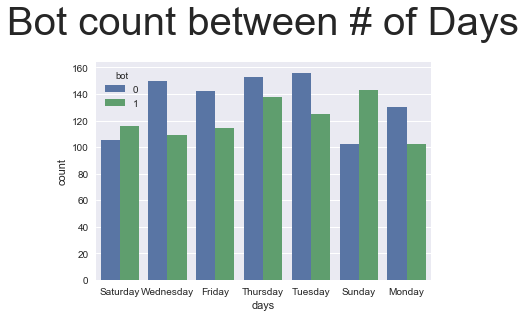

In [77]:
plt.title('Bot count between # of Days', size=40, y=1.1)
sns.countplot(x = 'days', hue='bot', data=train)